<a href="https://colab.research.google.com/github/arpdm/predictive-maintenance-platform/blob/main/dataset_analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
    Project Name: PdM Model for NASA Jet Engines
    Data: 10/9/2022
    Author: Arpi Derm
    Description: This model aims to use PdM model and RUL to predict failures in point time T in near future.
                 This specific model is built and trained for the NASA's PCoE Turbofan Engine Degradation (Run-To-Failure) dataset.
    Dataset Description: 
                Dataset description along with its variable can be found in the dataset paper written by 
                Manuel Arias Chao,Chetan Kulkarni, Kai Goebel and Olga Fink. https://dx.doi.org/10.3390/data6010005
    Variable Name Descriptions:
            w = Scenario-descriptor operating conditions (inputs to system model)
            x_s = sensor signal measurements (physical properties)
            x_v = virtual sensor signals
            t = engine health parameters 
            y_rul = target output Y - RUL (Remanding Useful Life) of engine unit
            aux = Auxiliary data such as cycle count, unit id, ...

    Notebook horizon with multiple cycles in advance
    https://colab.research.google.com/drive/1SGsU5jyuJVodUwAhf3Budeyh7c-gHXOR?usp=sharing#scrollTo=mXTILGKqWks0 

    Custom Learning Rate Scheduler
    https://colab.research.google.com/drive/1ceEa9Rs4BdGrfXfidwx-BpG-gtproWdQ#scrollTo=y6kJd40-0Hj9 
"""

# Colab data file preparation
from google.colab import drive

drive.mount("/content/drive/")

!cp drive/MyDrive/PdM/predictive-maintenance-platform/engine_data.py .
!cp drive/MyDrive/PdM/predictive-maintenance-platform/plot_util.py .
!cp drive/MyDrive/PdM/predictive-maintenance-platform/mark_001_model.py .
!cp drive/MyDrive/PdM/predictive-maintenance-platform/pcoe_engine_data_visualizer.py .


Mounted at /content/drive/


In [ ]:
pip install tensorflow-addons

In [3]:
import tensorflow as tf
import numpy as np

from engine_data import EngineData
from pcoe_engine_data_visualizer import PcoeEngingeVis
from plot_util import PlotUtil
from mark_001_model import Mark001Model

In [4]:
# Load all datasets
BASE_PATH = "/content/drive/MyDrive/PdM/data_set/"

DS_001 = BASE_PATH + "N-CMAPSS_DS01-005.h5"
DS_002 = BASE_PATH + "N-CMAPSS_DS02-006.h5"
DS_003 = BASE_PATH + "N-CMAPSS_DS03-012.h5"
DS_004 = BASE_PATH + "N-CMAPSS_DS04.h5"
DS_005 = BASE_PATH + "N-CMAPSS_DS05.h5"
DS_006 = BASE_PATH + "N-CMAPSS_DS06.h5"
DS_007 = BASE_PATH + "N-CMAPSS_DS07.h5"
DS_008 = BASE_PATH + "N-CMAPSS_DS08a-009.h5"
DS_009 = BASE_PATH + "N-CMAPSS_DS08c-008.h5"
DS_010 = BASE_PATH + "N-CMAPSS_DS08d-010.h5"

In [ ]:
# Load data set and prepare data frames
ed = EngineData()
pcoe_enging_vis = PcoeEngingeVis(ed)
plot_util = PlotUtil()
mark_001 = Mark001Model()

# Load Data from selected dataset file
ed.load_hdf5_to_numpy_arr(DS_001)

In [6]:
pcoe_enging_vis.get_engine_units_in_dataset()

Engine units in dataset:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Engine units in test dataset:  [ 7.  8.  9. 10.]
Engine units in train dataset:  [1. 2. 3. 4. 5. 6.]


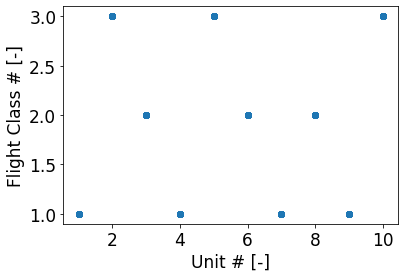

In [7]:
pcoe_enging_vis.plot_flight_classes()

In [15]:
# we want to know if the engine will fail in next cycle (flight) or not
# so labels are added to the dataset to be the outputs of 1 or 0
ed.df_x_s_test = ed.add_labels_to_dataset(ed.df_x_s_test,30,15)
ed.df_x_s_test = ed.normalize_dataset(ed.df_x_s_test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(


In [16]:
for engine_unit in np.unique(ed.df_aux_test["unit"]):
    cummulative_cycle_length_s = 0
    df_x_s_u_c = ed.df_x_s_test.loc[(ed.df_aux_test.unit == engine_unit)]
    going_to_fail = False
    for cycle in np.unique(ed.df_aux_test.cycle):
        df_x_s_u_c = ed.df_x_s_test.loc[(ed.df_aux_test.unit == engine_unit) & (ed.df_aux_test.cycle == cycle)]        
        cummulative_cycle_length_s += df_x_s_u_c.P21.size
        if df_x_s_u_c.label1.min()==1:
            going_to_fail = True
        print("Engine Unit = ", engine_unit, "Cycle = ", cycle, "Cycle_Duration (h) = " , round((df_x_s_u_c.P21.size/60)/60,2) , "Cycle_Duration (s) = " , df_x_s_u_c.P21.size, "Commulative Cycle Length (s) = ", cummulative_cycle_length_s, "L1 = ", df_x_s_u_c.label1.min(), "RUL = ", df_x_s_u_c.RUL.min(), "Going to Fail = ", going_to_fail)

Engine Unit =  7.0 Cycle =  1.0 Cycle_Duration (h) =  1.04 Cycle_Duration (s) =  3750 Commulative Cycle Length (s) =  3750 L1 =  0 RUL =  89 Going to Fail =  False
Engine Unit =  7.0 Cycle =  2.0 Cycle_Duration (h) =  1.38 Cycle_Duration (s) =  4958 Commulative Cycle Length (s) =  8708 L1 =  0 RUL =  88 Going to Fail =  False
Engine Unit =  7.0 Cycle =  3.0 Cycle_Duration (h) =  1.43 Cycle_Duration (s) =  5130 Commulative Cycle Length (s) =  13838 L1 =  0 RUL =  87 Going to Fail =  False
Engine Unit =  7.0 Cycle =  4.0 Cycle_Duration (h) =  1.38 Cycle_Duration (s) =  4958 Commulative Cycle Length (s) =  18796 L1 =  0 RUL =  86 Going to Fail =  False
Engine Unit =  7.0 Cycle =  5.0 Cycle_Duration (h) =  1.11 Cycle_Duration (s) =  4008 Commulative Cycle Length (s) =  22804 L1 =  0 RUL =  85 Going to Fail =  False
Engine Unit =  7.0 Cycle =  6.0 Cycle_Duration (h) =  1.29 Cycle_Duration (s) =  4660 Commulative Cycle Length (s) =  27464 L1 =  0 RUL =  84 Going to Fail =  False
Engine Unit 

<Figure size 432x288 with 0 Axes>

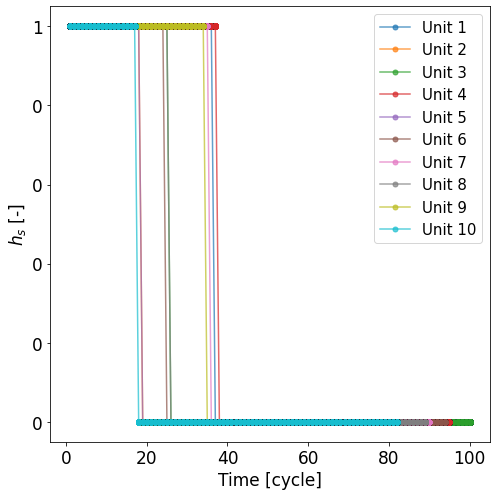

In [12]:
pcoe_enging_vis.plot_health_states_for_all_engines()

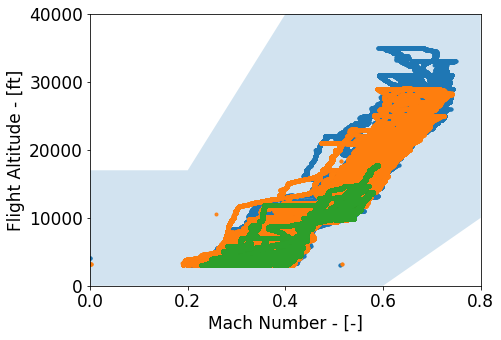

In [13]:
pcoe_enging_vis.generate_flight_envelope()

<Figure size 432x288 with 0 Axes>

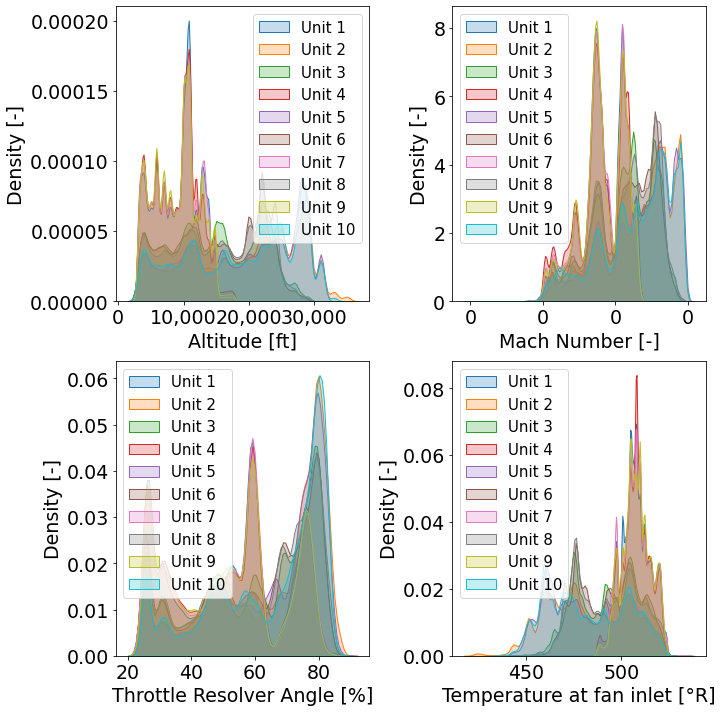

In [14]:
pcoe_enging_vis.generate_kde_estimations_of_flight_profile()